In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans

Reading in files

In [2]:
book_tags = pd.read_csv('C:/Users/aadia/Downloads/goodbooks-10k-master/goodbooks-10k-master/book_tags.csv')
books = pd.read_csv('C:/Users/aadia/Downloads/goodbooks-10k-master/goodbooks-10k-master/books.csv')
ratings = pd.read_csv('C:/Users/aadia/Downloads/goodbooks-10k-master/goodbooks-10k-master/ratings.csv')
tags = pd.read_csv('C:/Users/aadia/Downloads/goodbooks-10k-master/goodbooks-10k-master/tags.csv')
#to_read = pd.read_csv('C:/Users/aadia/Downloads/goodbooks-10k-master/goodbooks-10k-master/to_read.csv')

In [6]:
books[books['title']=='Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)']

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3274,3275,8,8,21457576,11,439682584,9.780440e+12,"J.K. Rowling, Mary GrandPré",2003.0,NaN,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",eng,4.77,33220,33424,156,317,233,978,3686,28210,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


In [4]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [25]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


Drop goodreads_book_id,best_book_id,work_id,isbn,isbn13,work_ratings_count,image_url,small_image_url,books_count

In [26]:
books_drop=books.drop(['goodreads_book_id','best_book_id','work_id','isbn','isbn13','work_ratings_count','image_url','small_image_url','books_count','original_title'],axis=1)

Replace the missing language code with eng

In [27]:
books['language_code']=books['language_code'].fillna(value=books.language_code.mode()[0])

Drop books with arabic titles

In [29]:
books_new=books_drop.drop(books_drop[(books_drop['language_code']=='ara')|(books_drop['language_code']=='per')].index,axis=0)

Drop Users that have submitted less than X ratings : Decided not to drop as 19 is a good number of ratings per user

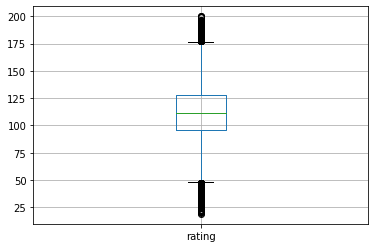

In [30]:
reviews_user=ratings.groupby('user_id')['rating'].count().sort_values().to_frame()
reviews_user.boxplot()

In [31]:
rating_count_per_user=np.array(reviews_user['rating'])
perc_5 = np.percentile(rating_count_per_user, 5)
perc_5

71.0

Remove Books that have less than X ratings

In [32]:
reviews_book=ratings.groupby('book_id')['rating'].count().sort_values().to_frame()
df=reviews_book.reset_index()
df

,book_id,rating
0,7803,8
1,9345,11
2,9486,24
3,1935,33
4,9315,36
5,9553,41
6,8181,45
7,9479,48
8,9260,48
9,9705,50


In [33]:
book=df.merge(books_new,left_on='book_id',right_on='book_id')

In [34]:
rating_count_per_book=np.array(reviews_book['rating'])
perc_50 = np.percentile(rating_count_per_book, 50)
perc_50

248.0

Now drop books books with less than 72 ratings

In [35]:
books_new1=book.drop(book[book['rating']<=248].index,axis=0)

Create eng/non-eng column

In [36]:
books_new1['language_code'] = books_new1['language_code'].astype('str')
books_new1['english_or_not'] = books_new1['language_code'].map(lambda x : 1 if 'en' in x else 0)

In [37]:
books_new1.shape

(4974, 15)

# Recommendations based on rating counts

In [39]:
sort_rating_book=books_new1[['title','rating']].sort_values('rating',ascending=False)

In [40]:
#Let's say top 5 recommendations
n=5
user_input='To Kill a Mockingbird'
sort_rating_book[(sort_rating_book['title']!=user_input)]['title'][0:n]

9928              The Hunger Games (The Hunger Games, #1)
9927    Harry Potter and the Sorcerer's Stone (Harry P...
9925                              Twilight (Twilight, #1)
9924                                     The Great Gatsby
9923                 Catching Fire (The Hunger Games, #2)
Name: title, dtype: object

Based on this, always recommend the top 5. This will only make the already succeeded books succeed more. Also, it is not personalized.

# Recommendation based on correlations

In [41]:
books_new1[['title','average_rating','rating']].sort_values('average_rating',ascending=False)

,title,average_rating,rating
7296,The Complete Calvin and Hobbes,4.82,482
5550,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77,285
9095,"Words of Radiance (The Stormlight Archive, #2)",4.77,1373
6649,It's a Magical World: A Calvin and Hobbes Coll...,4.75,384
5230,There's Treasure Everywhere: A Calvin and Hobb...,4.74,263
9360,"Harry Potter Boxset (Harry Potter, #1-7)",4.74,1915
8609,A Court of Mist and Fury (A Court of Thorns an...,4.72,933
5096,The Days Are Just Packed: A Calvin and Hobbes ...,4.68,256
5288,The Calvin and Hobbes Lazy Sunday Book,4.66,267
7672,"The Harry Potter Collection 1-4 (Harry Potter,...",4.66,560


We notice that Hunger Games which has the most number of ratings is not the one with the highest rating.So, the recommendations based on just rating counts, would definitely be a bad choice of a way to recommend.

Build a Rating Matrix

In [42]:
#just trying for 100 books
rat=ratings
ratings_pivot=rat.pivot(index='user_id',columns='book_id')
ratings_pivot[:2]

rating                                                              \
book_id  1     2     3     4     5     6     7     8     9     10    11      
user_id                                                                      
1          NaN   NaN   NaN   5.0   NaN   NaN   NaN   NaN   NaN   4.0   5.0   
2          NaN   5.0   NaN   NaN   5.0   NaN   NaN   4.0   NaN   5.0   NaN   

                                                                           \
book_id 12    13    14    15    16    17    18    19    20    21    22      
user_id                                                                     
1         NaN   4.0   NaN   NaN   3.0   NaN   NaN   NaN   NaN   NaN   3.0   
2         NaN   NaN   NaN   5.0   NaN   NaN   5.0   NaN   NaN   5.0   NaN   

                                                                           \
book_id 23    24    25    26    27    28    29    30    31    32    33      
user_id                                                                     
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   4.0   4.0   4.0   
2         5.0   5.0   5.0   4.0   5.0   NaN   3.0   NaN   NaN   NaN   4.0   

                                                                           \
book_id 34    35    36    37    38    39    40    41    42    43    44      
user_id                                                                     
1         NaN   5.0   4.0   NaN   2.0   NaN   2.0   NaN   3.0   4.0   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                                                           \
book_id 45    46    47    48    49    50    51    52    53    54    55      
user_id                                                                     
1         5.0   4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   

                                                                           \
book_id 56    57    58    59    60    61    62    63    64    65    66      
user_id                                                                     
1         NaN   3.0   NaN   NaN   3.0   NaN   NaN   NaN   NaN   NaN   4.0   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   

                                                                           \
book_id 67    68    69    70    71    72    73    74    75    76    77      
user_id                                                                     
1         3.0   NaN   NaN   5.0   NaN   3.0   NaN   NaN   NaN   3.0   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                                                           \
book_id 78    79    80    81    82    83    84    85    86    87    88      
user_id                                                                     
1         NaN   NaN   NaN   5.0   NaN   NaN   NaN   3.0   NaN   NaN   NaN   
2         NaN   NaN   5.0   NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   

                                                                           \
book_id 89    90    91    92    93    94    95    96    97    98    99      
user_id                                                                     
1         NaN   NaN   NaN   NaN   NaN   1.0   4.0   NaN   NaN   3.0   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                                                           \
book_id 100   101   102   103   104   105   106   107   108   109   110     
user_id                                                                     
1         4.0   NaN   5.0   3.0   NaN   NaN   NaN   NaN   NaN   3.0   NaN   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   

                                                                           \
book_id 111   112   113   114   115   116   117   118   119   120 

In [43]:
n=3
user_input_bookid=2
#create corr with the book entered
ratings_bookid=ratings_pivot['rating'][user_input_bookid]
similar_to_bookid=ratings_pivot.corrwith(ratings_bookid,axis=0,method='pearson').to_frame()
similar_to_bookid.dropna(inplace=True)

#get book title
corr_sum=similar_to_bookid.merge(books_new1,left_on='book_id',right_on='book_id')
result=corr_sum[corr_sum['rating']>300].sort_values(0,ascending=False)
result[(result['book_id']!=user_input_bookid)]['title'][0:n]

22      Harry Potter and the Chamber of Secrets (Harry...
2080    The Harry Potter Collection 1-4 (Harry Potter,...
17      Harry Potter and the Prisoner of Azkaban (Harr...
Name: title, dtype: object

This definitely seems to be a better recommendation than just the one based on rating count. For an input of a Harry Potter book, it is recommending other Harry Potter books.

Let's try to make it even better!

# Content-based filtering

We should ideally be looking at book descriptions for this. Since, we do not have access to the descriptions, let's try to do it based on the title of books. This method, since it depends on the content data of the product, it solves the problem of recommending items to new users.

In [44]:
books_new1.head()

,book_id,rating,authors,original_publication_year,title,language_code,average_rating,ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,english_or_not
4955,7563,249,John Updike,1981.0,Rabbit Is Rich (Rabbit Angstrom #3),eng,3.90,12455,499,379,777,2914,4970,4260,1
4956,5328,249,Jennifer A. Nielsen,2013.0,"The Runaway King (The Ascendance Trilogy, #2)",eng,4.23,24032,2859,201,680,3764,9571,11577,1
4957,5122,249,Hunter S. Thompson,1973.0,Fear and Loathing on the Campaign Trail '72,en-US,4.10,15306,701,85,562,3216,6417,6322,1
4958,4808,249,Charlie N. Holmberg,2014.0,The Glass Magician (The Paper Magician Trilogy...,nan,3.87,13650,1786,174,1149,6238,9437,5976,0
4959,6083,249,"Stephen Briggs, Terry Pratchett",1992.0,Guards! Guards!: The Play,en-GB,4.35,15096,40,64,182,1815,5420,7645,1


In [54]:
books_new1[books_new1['book_id']==96]

,book_id,rating,authors,original_publication_year,title,language_code,average_rating,ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,english_or_not
9735,96,4185,E.L. James,2012.0,"Fifty Shades Freed (Fifty Shades, #3)",eng,3.88,387290,25287,39079,55691,109963,140304,265079,1


In [53]:
ds = pd.DataFrame({'ID':books_new1['title'].index, 'Title':books_new1['title'].values})
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['Title'])
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
results = {}
for index,value in ds.iterrows(): #iterates through all the rows
    similar_indices = cosine_similarities[index].argsort()[:-6:-1]
    similar_items = [(cosine_similarities[index][i], ds['ID'][i]) for i in similar_indices]
    results[value['ID']] = similar_items[1:]

In [51]:
ds.to_csv('ds.csv')

In [55]:
def item(id):
    return ds.loc[ds['ID'] == id]['Title'].tolist()[0]
def recommend(id, num):
    if (num == 0):
        print("Unable to recommend any book as you have not chosen the number of book to be recommended")
    elif (num==1):
        print("Recommending " + str(num) + " book similar to " + item(id))   
    else :
        print("Recommending " + str(num) + " books similar to " + item(id))
        
    recs = results[id][:num]
    for rec in recs:
        print("You may also like to read: " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

recommend(5550,5)

Recommending 5 books similar to Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)
You may also like to read: The Harry Potter Collection 1-4 (Harry Potter, #1-4) (score:0.44515336153682256)
You may also like to read: Harry Potter Boxset (Harry Potter, #1-7) (score:0.4404385996100326)
You may also like to read: Harry Potter and the Goblet of Fire (Harry Potter, #4) (score:0.43884033133459033)
You may also like to read: Harry Potter and the Chamber of Secrets (Harry Potter, #2) (score:0.4061915692350329)


This seems like a reasonable list of recommendation.
Note : This would be more useful for a set of books on a particular wide subject area like data science where users might be interested in a specific topic. Does not necessarily work well for a set of fiction books.

Having used the title of the book for content based recommendation, let's now try with author names. It's very similar to the one we did above. Our expectation is that when a book from an author is given as input, it should recommend other books written by the same author.

In [25]:
ds1 = pd.DataFrame({'ID':books_new1['authors'].index, 'Author':books_new1['authors'].values,'Title':books_new1['title'].values})
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds1['Author'])
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
results = {}
for index,value in ds1.iterrows(): #iterates through all the rows
    similar_indices = cosine_similarities[index].argsort()[:-6:-1]
    similar_items = [(cosine_similarities[index][i], ds1['ID'][i]) for i in similar_indices]
    results[value['ID']] = similar_items[1:]

In [26]:
tfidf_matrix

<9833x19728 sparse matrix of type '<class 'numpy.float64'>'
	with 49379 stored elements in Compressed Sparse Row format>

In [27]:
cosine_similarities.shape

(9833, 9833)

In [28]:
def item(id):
    return ds1.loc[ds1['ID'] == id]['Author'].tolist()[0]
def book(id):
    return ds1.loc[ds1['ID'] == id]['Title'].tolist()[0]
def recommend(id, num):
    if (num == 0):
        print("Unable to recommend any book as you have not chosen the number of book to be recommended")    
    else :
        print("Recommending " + str(num) + " books written by " + item(id))

    recs = results[id][:num]
    for rec in recs: 
        print("You may also like to read: " + book(rec[1]) + " by author " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

recommend(5550,5)

Recommending 5 books written by J.K. Rowling, Mary GrandPré
----------------------------------------------------------
You may also like to read: Harry Potter and the Deathly Hallows (Harry Potter, #7) by author J.K. Rowling, Mary GrandPré (score:1.0)
You may also like to read: Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5) by author J.K. Rowling, Mary GrandPré (score:1.0)
You may also like to read: The Harry Potter Collection 1-4 (Harry Potter, #1-4) by author J.K. Rowling, Mary GrandPré (score:1.0)
You may also like to read: Harry Potter and the Sorcerer's Stone (Harry Potter, #1) by author J.K. Rowling, Mary GrandPré (score:1.0)


Of course, the next best thing to do is a hybrid (model that takes title and author into consideration). Let's try that!

In [29]:
ds1 = pd.DataFrame({'ID':books_new1['authors'].index, 'Author':books_new1['authors'].values,'Title':books_new1['title'].values})
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds1['Author']+ds1['Title'])
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)
results = {}
for index,value in ds1.iterrows(): #iterates through all the rows
    similar_indices = cosine_similarities[index].argsort()[:-6:-1]
    similar_items = [(cosine_similarities[index][i], ds1['ID'][i]) for i in similar_indices]
    results[value['ID']] = similar_items[1:]

In [30]:
def item(id):
    return ds1.loc[ds1['ID'] == id]['Author'].tolist()[0]
def book(id):
    return ds1.loc[ds1['ID'] == id]['Title'].tolist()[0]
def recommend(id, num):
    if (num == 0):
        print("Unable to recommend any book as you have not chosen the number of book to be recommended")    
    else :
        print("Recommending " + str(num) + " similar books to  " + book(id) + " written by " + item(id))
        
    recs = results[id][:num]
    for rec in recs:
        print("You may also like to read: " + book(rec[1]) + " by author " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

recommend(96,5)

Recommending 5 similar books to  India After Gandhi: The History of the World's Largest Democracy written by Ramachandra Guha
----------------------------------------------------------
You may also like to read: A History of the World in 6 Glasses by author Tom Standage (score:0.11840264113061365)
You may also like to read: The Ascent of Money: A Financial History of the World by author Niall Ferguson (score:0.09399130636002426)
You may also like to read: A Little History of the World by author E.H. Gombrich, Caroline Mustill, Clifford Harper (score:0.08692473478332437)
You may also like to read: Salt: A World History by author Mark Kurlansky (score:0.06747384410409528)


While this works and gives out similar books to the one when we used just the title of this book, the similarity scores have gone down.

# Clustering

Let's now try to cluster similar books together.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [4]:
filtered_data = pd.read_csv('C:/Users/aadia/Downloads/filtered_ratings_data_1102_idea1.csv')

In [5]:
filtered_data.shape

(153649, 4)

In [5]:
filtered_author=filtered_data.merge(books,left_on='book_id',right_on='book_id')[['book_id','authors','title']].drop_duplicates()

In [7]:
filtered_author.shape

(5777, 3)

In [6]:
ds1 = pd.DataFrame({'ID':filtered_author['book_id'], 'Author':filtered_author['authors'].values,'Title':filtered_author['title'].values})
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds1['Author']+ds1['Title'])

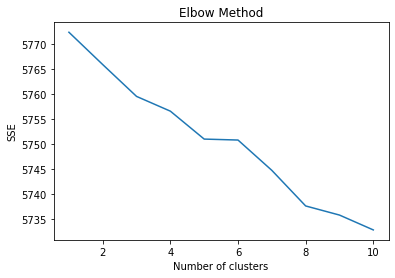

In [7]:
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=3,random_state=0)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [9]:
clusters = KMeans(n_clusters=10, init='k-means++', random_state=20)
clusters.fit_predict(tfidf_matrix)

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
segments=clusters.labels_
seg=pd.DataFrame(segments)
seg[0].value_counts()

0    4828
9     180
5     173
1     135
6     133
3      80
8      80
4      73
7      63
2      32
Name: 0, dtype: int64

In [12]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[term] for term in np.argsort(r)[-n_terms:]]))

In [27]:
get_top_keywords(tfidf_matrix, clusters, tf.get_feature_names(), 10)


Cluster 0
patterson,james patterson,harry bosch,bosch,patricia,meg,harry,william,michael,david

Cluster 1
stark trilogy,stark,empire,dream,magician,winner,shannara,nora,robin,trilogy

Cluster 2
night huntress,huntress,little house,jeaniene,cast kristin,cast,house night,kristin,house,night

Cluster 3
children red king,children red,red king,earth children,auelthe,jean auelthe,bear,jean,earth,children

Cluster 4
marzán,josé marzán jr,jr man,man,kurt,vonnegut,vonnegut jr,kurt vonnegut jr,kurt vonnegut,jr

Cluster 5
richard bachman stephen,richard bachman,bachman stephen,dark,bachman,king,stephen king,kingthe,stephen kingthe,stephen

Cluster 6
flanaganthe,apprentice,john flanaganthe,john corey,corey,ranger,ranger apprentice,grishamthe,john grishamthe,john

Cluster 7
life,vampire,sarah,richard,dean,jennifer,anne,chronicles,james,robert


Let's name the clusters. . . This is done by searching and reading about the books that these authors write. Also, the assumption is that an author writes books in one genre.

We see that cluster 7 has 4398 books and cluster 0 has 741 books. We are going to take only these two clusters and see how our model performs.

In [13]:
seg=pd.DataFrame(segments)
seg=seg.reset_index()

In [14]:
filtered_author.insert(0, '_ID', range(0, 0 + len(filtered_author)))

In [15]:
merge=filtered_author.merge(seg,left_on='_ID',right_on='index')

In [16]:
merge=merge.rename(columns={0: "cluster_num"})

In [17]:
merge.to_csv('merge.csv')

In [18]:
merge['cluster_num'].value_counts()

7    4398
0     741
6     168
2     137
1     122
5     118
3      69
4      24
Name: cluster_num, dtype: int64

In [22]:
cl_7=merge[merge['cluster_num']==7]

In [23]:
cl_7.to_csv('cluster_7.csv')

In [24]:
cl_0=merge[merge['cluster_num']==0]

In [28]:
cl_0.to_csv('cluster_0.csv')